I'm gonna start with the Regularized linear models as my benchmark estimators!
Models to be implemented in this notebook:
- Ridge Regression
- Lasso Regression
- Elastic

But first lets import some dependencies and our data

In [22]:
# importing the dependencies
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , KFold, learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# loading our data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [3]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Lets make our X and y respectively

In [4]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

In [5]:
X.shape, y.shape

((1826, 1), (1826, 1))

Making train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### Power Transform (Box-Cox)

In [7]:
pt = PowerTransformer(method='box-cox')
X_train_transformed = pt.fit_transform(X_train+0.000001)
X_test_transformed = pt.transform(X_test+0.000001)

In [8]:
pt.lambdas_

array([-0.10662485])

In [9]:
y_train_transformed = pt.fit_transform(y_train+0.000001)
y_test_transformed = pt.transform(y_test+0.000001)

In [10]:
pt.lambdas_

array([-5.34754941])

### Model Building

#### Ridge Regression
*Linear least squares with l2 regularization.*

lets now initialize our CV and model with default parameters provided by sklearn!

In [11]:
kflod = KFold(n_splits=5,shuffle=True, random_state=17)
ridge_regression =  Ridge(random_state=17)

lets check our CV scores with default parameters

In [12]:
results = cross_val_score(
    ridge_regression,
    X_train_transformed,
    y_train_transformed,
    cv=kflod,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.605630841351809

Lets check for train test accuracy now

In [13]:
ridge_regression.fit(X_train_transformed,y_train_transformed)

Ridge(random_state=17)

In [14]:
# accuracy on the train set
ridge_pred = ridge_regression.predict(X_train_transformed)
mean_absolute_error(y_train_transformed,ridge_pred)

0.6055762485546179

In [15]:
# accuracy on the test set
ridge_pred = ridge_regression.predict(X_test_transformed)
mean_absolute_error(y_test_transformed,ridge_pred)

0.6011885371212594

#### Learning Curve

In [21]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [23]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        ridge_regression,X_train_transformed,y_train_transformed, train_sizes=train_sizes,cv=kflod,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

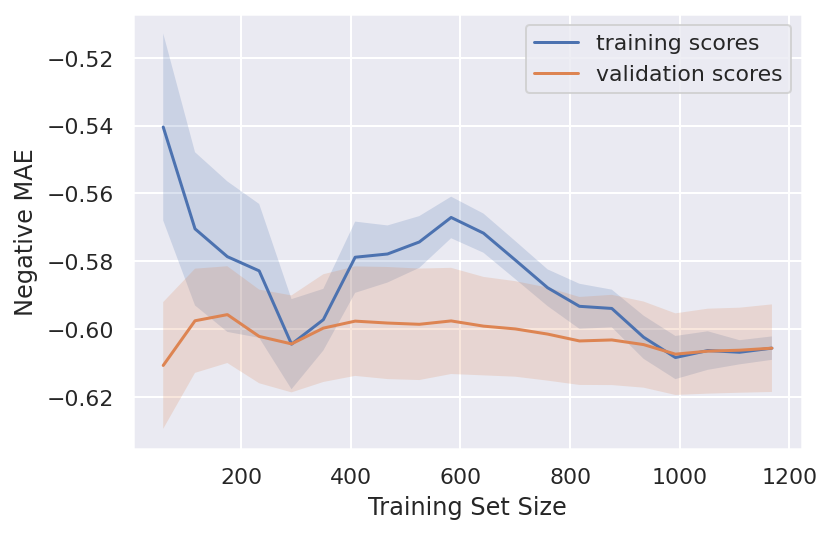

In [24]:
plot_learning_curve()

Note:
- Theres seems like no variance problem, thus tuning the hyperparameter alpha wont do much good here! So lets move onto LASSO!
- by MAE 0.6 means that, on average model is 0.6 meter wrong on predicting the correct value of water level! 

#### Lasso Regression
*Linear Model trained with L1 prior as regularizer (aka the Lasso).*

In [16]:
kflod = KFold(n_splits=5,shuffle=True, random_state=17)
lasso_regression = Lasso(random_state=17, max_iter=10000)

In [17]:
results = cross_val_score(
    lasso_regression,
    X_train_transformed,
    y_train_transformed,
    cv=kflod,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.8732801748385459

In [18]:
lasso_regression.fit(X_train_transformed,y_train_transformed)

Lasso(max_iter=10000, random_state=17)

In [19]:
# accuracy on the train set
lasso_pred = lasso_regression.predict(X_train_transformed)
mean_absolute_error(y_train_transformed,lasso_pred)

0.8729811451213172

In [20]:
# accuracy on the test set
lasso_pred = lasso_regression.predict(X_test_transformed)
mean_absolute_error(y_test_transformed,lasso_pred)

0.8666496419855901

#### Learning Curve

In [25]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        lasso_regression,X_train_transformed,y_train_transformed, train_sizes=train_sizes,cv=kflod,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

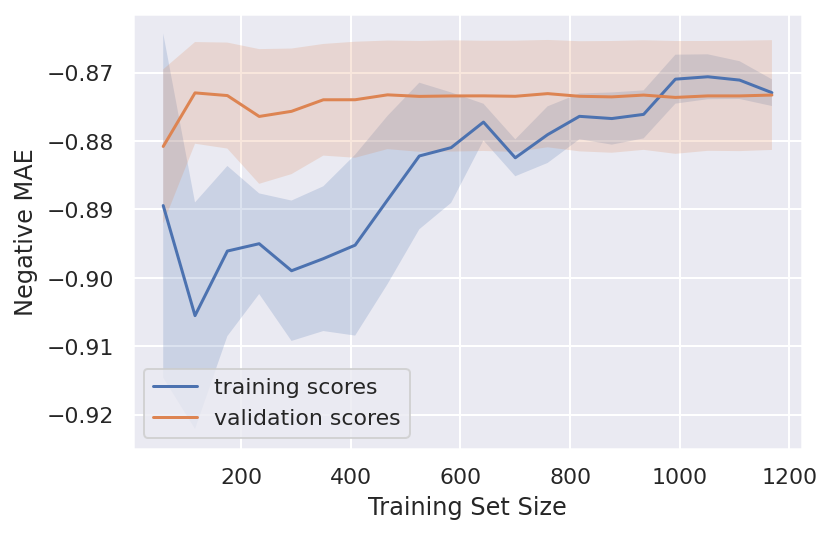

In [26]:
plot_learning_curve()